In [0]:
from __future__ import print_function, division
import os
import torch
from torch.optim.optimizer import Optimizer
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

from torch.utils.tensorboard import SummaryWriter

import PIL
from PIL import Image

from google.colab import output

In [2]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

num_of_classes = 3

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3937 (delta 0), reused 2 (delta 0), pack-reused 3933
Receiving objects: 100% (3937/3937), 187.60 MiB | 38.94 MiB/s, done.
Resolving deltas: 100% (607/607), done.


In [0]:
class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root

  def __len__(self):
    lt = 0
    classes = os.listdir(self.root)
    for cl in classes:
      lt += len(os.listdir(self.root + '/' + cl))

    return lt

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
     idx = idx.tolist()

    if(idx <= len(self)):
      found_file = ""
      found_type = ""

      fldrs = os.listdir(self.root)
      for fld in fldrs:
        fls = os.listdir(self.root + '/' + fld + '/')
        for fl in fls:
          if(fl == str(idx) + ".jpg"):
            found_file = self.root + '/' + fld + '/' + fl         
            found_type = fld

      try:
        img = io.imread(found_file)
        img = rgb2gray(img)

        return {'image': img, 'class_name': found_type}
      except:
        if(found_file != ""):
          print("Bad file: " + found_file)
        else:
          print("File not found, idx = " + str(idx))
    else:
      print()
      raise Exception("Dataset index out of boundaries")

train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/training')
val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/val')
test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/test')

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

In [0]:
class custom_sgd_optimizer(Optimizer):
    def __init__(self, params, lr, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(custom_sgd_optimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(custom_sgd_optimizer, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group['lr'])

        return loss

In [6]:
network = Net(4096, 1500, 300, num_of_classes)
network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.6)
criterion = nn.MSELoss().cuda()

print(network)

Net(
  (fc1): Linear(in_features=4096, out_features=1500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1500, out_features=300, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=300, out_features=3, bias=True)
)


In [0]:
network.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/model.pth'))
network.eval()

optimizer = torch.optim.SGD(network.parameters(), lr=0.2, momentum=0.2)
optimizer.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/optimizer.pth'))

In [9]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network.to(dev)
criterion.to(dev)
dev

device(type='cuda')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True)

Class name: B


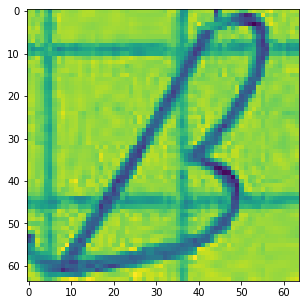

In [12]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
img = itr['image']
print("Class name: {}".format(label[0]))

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img[0])

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]

In [0]:
!mkdir results

In [0]:
def name_to_int(data):

  switcher = {
      'A': 1,
      'B': 2,
      'C': 3,
      'A_small': 1,
      'P': 2,
      'u': 3
  }

  new_data = []

  for dt in data:
    new_data.append(switcher.get(dt))

  return new_data

In [0]:
def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [53]:
def train(train_loader, val_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  val_loss_hist = []
  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_images_train = 0
    num_images_val = 0

    # TRAINING DATASET
    correct = 0
    for data in train_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      num_images_train = len(images)

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.zeros(num_of_classes)
        real_value[labels[idx] - 1] = 1

        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 
        
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()

    # VALIDATION
    for data in val_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      images.cuda()
      labels.cuda()

      num_images_val = len(images)

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        if(labels[idx] == get_max_from_tensor(outputs)):
          correct += 1

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.zeros(num_of_classes)
        real_value[labels[idx] - 1] = 1
        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 

        lossSum += loss.item()
        val_loss_hist.append(lossSum)

    print("Epoch: {} Training loss: {} Eval loss: {} Correct: {}%".format(epoch,train_loss_hist[len(train_loss_hist) - 1],val_loss_hist[len(val_loss_hist) - 1],correct*100/num_images_train))

    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

train(train_loader, val_loader, 10, 5)

Epoch: 0 Training loss: 26.759463170543313 Eval loss: 7.562610916793346 Correct: 13.675213675213675%
Epoch: 1 Training loss: 24.141010895371437 Eval loss: 6.896617621183395 Correct: 20.512820512820515%
Epoch: 2 Training loss: 21.758808713406324 Eval loss: 7.124455824494362 Correct: 9.401709401709402%
Epoch: 3 Training loss: 18.46321166586131 Eval loss: 4.9888112507760525 Correct: 21.367521367521366%
Epoch: 4 Training loss: 15.132412670180202 Eval loss: 4.743787434883416 Correct: 21.367521367521366%
Epoch: 5 Training loss: 14.382680334849283 Eval loss: 3.677587201818824 Correct: 23.931623931623932%
Epoch: 6 Training loss: 12.562257289479021 Eval loss: 4.277231915970333 Correct: 22.22222222222222%
Epoch: 7 Training loss: 10.513414894783637 Eval loss: 2.5645518478995655 Correct: 24.786324786324787%
Epoch: 8 Training loss: 8.287758937425679 Eval loss: 3.5416133161634207 Correct: 22.22222222222222%
Epoch: 9 Training loss: 6.945993163215462 Eval loss: 2.4281842074124143 Correct: 28.205128205

In [0]:
for data in test_loader:
  images = data['image']
  labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

  for i in range(len(images)):
    output = network(images[i].cuda().flatten().float())
    
    if(get_max_from_tensor(output) == labels[i]):
      print("OK: {} == {} Probability: {}".format(get_max_from_tensor(output), labels[i], output[get_max_from_tensor(output) - 1]))
    else:
      print("False: {} == {} Probability: {}".format(get_max_from_tensor(output), labels[i], output[get_max_from_tensor(output) - 1]))

OK: 3 == 3 Probability: 0.860595703125
OK: 2 == 2 Probability: 1.0670024156570435
OK: 3 == 3 Probability: 0.9735060334205627
OK: 2 == 2 Probability: 0.646336555480957
OK: 1 == 1 Probability: 0.8910107612609863
OK: 3 == 3 Probability: 0.8794940114021301
OK: 2 == 2 Probability: 0.9447812438011169
OK: 3 == 3 Probability: 0.7588624954223633
OK: 2 == 2 Probability: 1.0152208805084229
OK: 3 == 3 Probability: 0.6961532831192017
OK: 3 == 3 Probability: 0.928891122341156
OK: 1 == 1 Probability: 0.8031685948371887
OK: 2 == 2 Probability: 0.9491794109344482
OK: 3 == 3 Probability: 0.8562600612640381
OK: 1 == 1 Probability: 1.102687120437622
OK: 2 == 2 Probability: 1.0187582969665527
OK: 2 == 2 Probability: 0.7778895497322083
OK: 1 == 1 Probability: 0.988864541053772
OK: 2 == 2 Probability: 1.0590862035751343
OK: 1 == 1 Probability: 0.728187084197998
OK: 1 == 1 Probability: 0.8701620101928711
OK: 1 == 1 Probability: 0.8838222026824951
OK: 2 == 2 Probability: 0.9105136394500732


In [0]:
for opt in optimizer.param_groups:
  opt['lr'] = 0.01

In [0]:
!cp '/content/results/model.pth' '/content/Lithuanian_OCR/Trained_model/model.pth'
!cp '/content/results/optimizer.pth' '/content/Lithuanian_OCR/Trained_model/optimizer.pth'